In [ ]:
# !pip install --upgrade scikit-learn

### 1. Imports des modules

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


### 2. Lecture des données

In [19]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

In [20]:
smartwatch_df.head()

,index,source,timestamp,values
0,164349,battery,2017-06-29 07:45:56.262,['98']
1,164350,accelerometer,2017-06-29 07:46:01.263,"['-0.3440857', '0.68330383', '9.967361']"
2,164351,gravity,2017-06-29 07:46:01.324,"['-0.34131828', '0.6573288', '9.778641']"
3,164352,linear_acceleration,2017-06-29 07:46:01.329,"['-0.018068999', '0.034808993', '-0.033065796']"
4,164353,gyroscope,2017-06-29 07:46:01.402,"['0.0041656494', '-0.0132751465', '0.006164551']"


In [21]:
data = {}

data['battery'] = [None] * len(smartwatch_df)
data['pressure'] = [None] * len(smartwatch_df)
data['heart_rate'] = [None] * len(smartwatch_df)
# data['step_counter'] = [None] * len(smartwatch_df)
data['steps'] = [None] * len(smartwatch_df)
data['accelerometer'] = [None] * len(smartwatch_df)
# data['gravity'] = [None] * len(smartwatch_df)
# data['linear_acceleration'] = [None] * len(smartwatch_df)
# data['orientation'] = [None] * len(smartwatch_df)
# data['magnetometer'] = [None] * len(smartwatch_df)
# data['rotation_vector'] = [None] * len(smartwatch_df)


for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'battery':
        data['battery'][index] = values[0]
    
    if row['source'] == 'pressure':
        data['pressure'][index] = values[0]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]

#     if row['source'] == 'step_counter':
#         data['step_counter'][index] = values[0]

    if row['source'] == 'step_detector':
        data['steps'][index] = values[0]
    
    if row['source'] == 'accelerometer':
        data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

#     if row['source'] == 'gravity':
#         data['gravity'][index] = (sum([x**2 for x in values]))**0.5

#     if row['source'] == 'linear_acceleration':
#         data['linear_acceleration'][index] = (sum([x**2 for x in values]))**0.5

#     if row['source'] == 'orientation':
#         data['orientation'][index] = (sum([x**2 for x in values]))**0.5
        
#     if row['source'] == 'magnetometer':
#         data['magnetometer'][index] = (sum([x**2 for x in values]))**0.5
        

smartwatch_df["battery"] = data['battery']
smartwatch_df["pressure"] = data['pressure']
smartwatch_df["heart_rate"] = data['heart_rate']
smartwatch_df["steps"] = data['steps']
smartwatch_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'battery': np.mean,
    'pressure': np.mean,
    'heart_rate': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['battery'].notnull() | 
                                smartwatch_df['pressure'].notnull() | 
                                smartwatch_df['heart_rate'].notnull() | 
                                smartwatch_df['steps'].notnull() |
                                smartwatch_df['accelerometer'].notnull()
    
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df[['battery','pressure','heart_rate','steps', 'accelerometer']]
smartwatch_df = smartwatch_df.resample('min').agg(resampling_functions)
smartwatch_df['steps'].fillna(0.0, inplace=True)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

,battery,pressure,heart_rate,steps,accelerometer
timestamp,,,,,
2017-06-29 07:46:00,98.0,968.714862,129.568182,0.0,9.871610
2017-06-29 07:47:00,97.0,968.387418,111.095238,2.0,9.870039
2017-06-29 07:48:00,97.0,969.122270,75.076923,2.0,9.941302
2017-06-29 07:49:00,97.0,968.621508,68.076923,2.0,9.873130
2017-06-29 07:50:00,96.0,969.267466,64.666667,0.0,9.451193


In [22]:
len(smartwatch_df)

3064

In [23]:
smartwatch_df.loc[smartwatch_df['steps']<=3, 'steps'] = 0
smartwatch_df.loc[smartwatch_df['steps']>3, 'steps'] = 1
smartwatch_df.head()

,battery,pressure,heart_rate,steps,accelerometer
timestamp,,,,,
2017-06-29 07:46:00,98.0,968.714862,129.568182,0.0,9.871610
2017-06-29 07:47:00,97.0,968.387418,111.095238,0.0,9.870039
2017-06-29 07:48:00,97.0,969.122270,75.076923,0.0,9.941302
2017-06-29 07:49:00,97.0,968.621508,68.076923,0.0,9.873130
2017-06-29 07:50:00,96.0,969.267466,64.666667,0.0,9.451193


In [24]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [25]:
data = {}
data['activity_index'] = [None] * len(smartwatch_df)
data['activity_type'] = [None] * len(smartwatch_df)

i=0
for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_index'][i] = int(report_row['index'])
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

smartwatch_df["activity_index"] = data['activity_index']
smartwatch_df["activity_type"] = data['activity_type']
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=3064), HTML(value='')))

,battery,pressure,heart_rate,steps,accelerometer,activity_index,activity_type
timestamp,,,,,,,
2017-06-29 09:57:00,82.0,963.995217,76.083333,1.0,10.090378,12.0,Eat
2017-06-29 10:01:00,81.0,964.902750,58.784810,0.0,10.004682,12.0,Eat
2017-06-29 10:02:00,81.0,963.848278,71.727273,1.0,12.531055,12.0,Eat
2017-06-29 10:03:00,81.0,964.089400,91.750000,1.0,10.724664,12.0,Eat
2017-06-29 10:04:00,81.0,965.504640,105.000000,1.0,7.006813,12.0,Eat


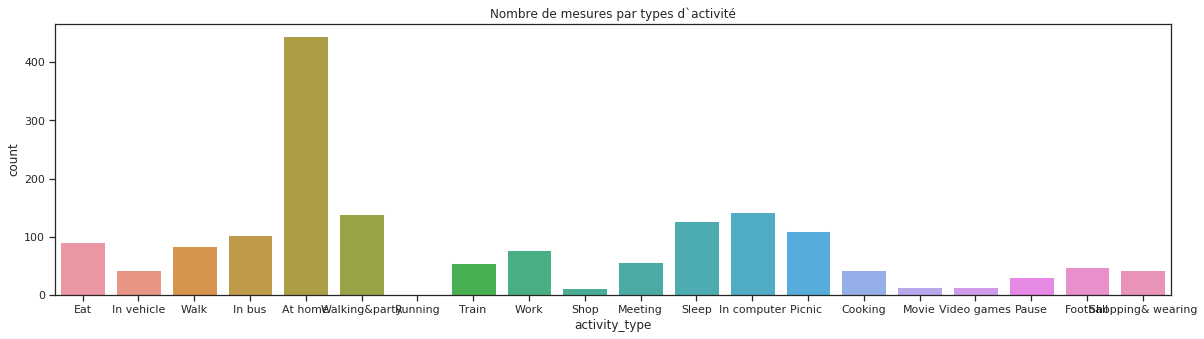

In [26]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=smartwatch_df).set_title('Nombre de mesures par types d`activité')

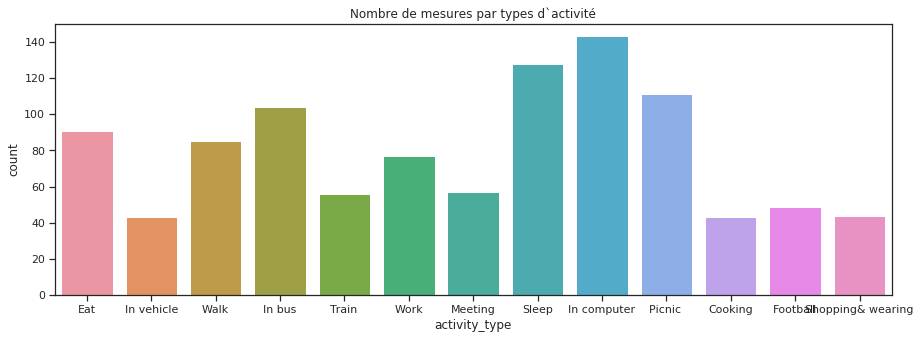

In [27]:
smartwatch_df = smartwatch_df.drop(smartwatch_df.index[smartwatch_df['activity_type'] == 'At home'], axis = 0)
smartwatch_df = smartwatch_df.drop(smartwatch_df.index[smartwatch_df['activity_type'] == 'Walking&party'], axis = 0)
for activity_type in smartwatch_df['activity_type'].unique():
    if len(smartwatch_df[smartwatch_df['activity_type'] == activity_type])<40:
        smartwatch_df = smartwatch_df.drop(smartwatch_df.index[smartwatch_df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=smartwatch_df).set_title('Nombre de mesures par types d`activité')

In [28]:
variables = [
#     'battery', 
#     'pressure', 
    'heart_rate', 
    'steps',
    'accelerometer'
]

# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(smartwatch_df[variables])
smartwatch_normal = normal_scaler_fit.transform(smartwatch_df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(smartwatch_normal, columns=variables)

y = smartwatch_df['activity_type']

smartwatch_df_normal = pd.DataFrame(smartwatch_normal, columns=variables)
smartwatch_df_normal['activity_type'] = smartwatch_df['activity_type'].tolist()

In [29]:
smartwatch_df_normal.head()

,heart_rate,steps,accelerometer,activity_type
0,0.444152,2.117556,-0.014179,Eat
1,-0.912357,-0.472243,-0.092540,Eat
2,0.102560,2.117556,2.217602,Eat
3,1.672695,2.117556,0.565819,Eat
4,2.711728,2.117556,-2.833822,Eat


In [30]:
smartwatch_df[variables].describe()

,heart_rate,steps,accelerometer
count,1031.000000,1031.000000,1031.000000
mean,70.419406,0.182347,10.105884
std,12.758424,0.386318,1.094132
min,47.600000,0.000000,6.277848
25%,61.837719,0.000000,9.755921
50%,67.619048,0.000000,9.869482
75%,75.408333,0.000000,10.024585
max,121.500000,1.000000,21.498993


In [31]:
smartwatch_df_normal.describe()

,heart_rate,steps,accelerometer
count,1.031000e+03,1.031000e+03,1.031000e+03
mean,9.676224e-16,1.214784e-15,1.355743e-16
std,1.000485e+00,1.000485e+00,1.000485e+00
min,-1.789444e+00,-4.722426e-01,-3.500396e+00
25%,-6.729555e-01,-4.722426e-01,-3.200094e-01
50%,-2.195974e-01,-4.722426e-01,-2.161680e-01
75%,3.912199e-01,-4.722426e-01,-7.434041e-02
max,4.005619e+00,2.117556e+00,1.041798e+01


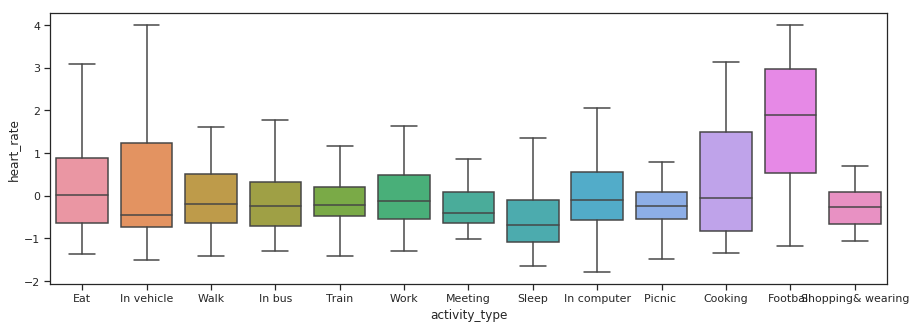

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="heart_rate", data=smartwatch_df_normal, showfliers=False)

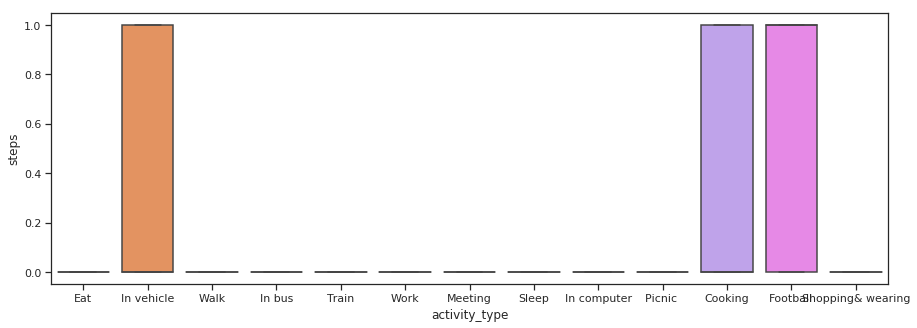

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="steps", data=smartwatch_df, showfliers=False)

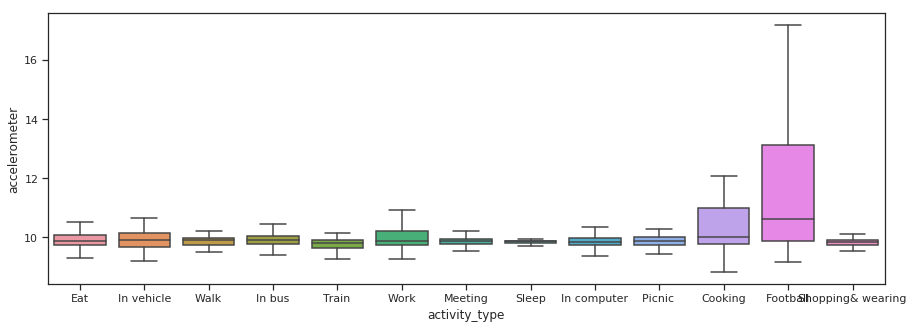

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.boxplot(x="activity_type", y="accelerometer", data=smartwatch_df, showfliers=False)

### 4.  Corrélations

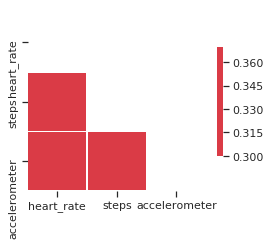

In [35]:
# Matrice de correlation
corr = X.corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### 4.  Analyse par Composantes Principales

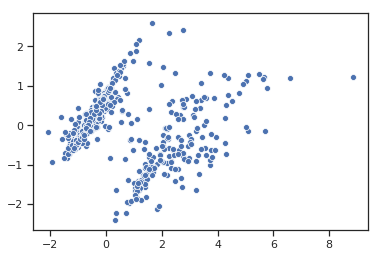

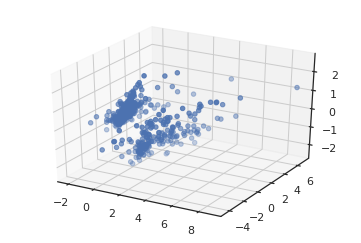

 
Explained variances:
[0.6345718374106663, 0.23195666413486024, 0.13347149845447365]
 
Sum of explained variances: 1.0000000000000002
 


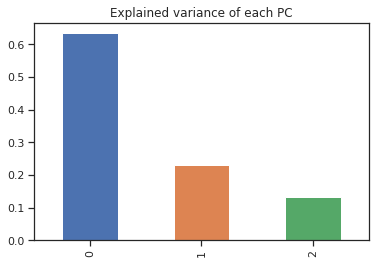

In [36]:
n_components = 3
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

## 5. Classification non-supervisée

### 5.1. CAH

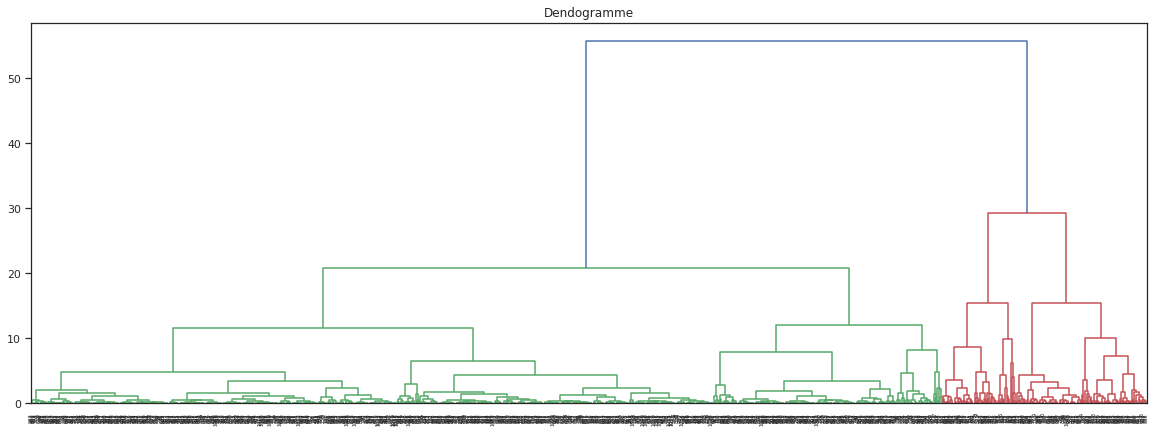

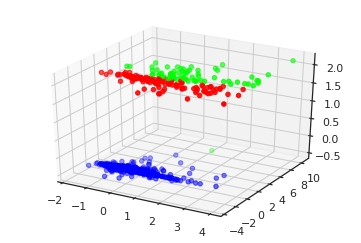

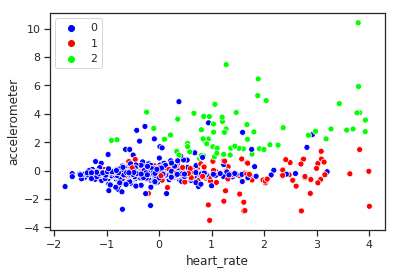

In [37]:
plt.figure(figsize=(20, 7))  
plt.title("Dendogramme")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))    

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X) 

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['heart_rate'], X['accelerometer'], X['steps'], c=cluster.labels_, cmap = 'brg')

# plt.show()
# sns.scatterplot(X['heart_rate'],X['steps'], hue=cluster.labels_, palette = 'brg')

plt.show()
sns.scatterplot(X['heart_rate'],X['accelerometer'],  hue=cluster.labels_, palette = 'brg')

# plt.show()
# sns.scatterplot(X['steps'],X['accelerometer'],  hue=cluster.labels_, palette = 'brg')

# X['predictions'] = cluster.labels_
# X['activity_type'] = smartwatch_df['activity_type'].tolist()
# for prediction in X['predictions'].unique():
#     proportions = []
#     labels = []
#     for activity_type in X[X['predictions'] == prediction]['activity_type'].unique():
#         p = X[X['predictions'] == prediction]['activity_type'].value_counts()[activity_type]
#         n = X['activity_type'].value_counts()[activity_type]
#         proportions.append(p/n)
#         labels.append(activity_type)
     
#     plt.show()
#     fig, ax = plt.subplots(figsize=(6,3))
#     sns.barplot(x = labels, y = proportions)
    
# X = X.drop('predictions', axis = 1)
# X = X.drop('activity_type', axis = 1)  

In [38]:
# from sklearn.cluster import DBSCAN

# cluster = DBSCAN(eps=3, min_samples=2).fit(X)

# plt.show()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X['heart_rate'], X['accelerometer'], X['steps'], c=cluster.labels_, cmap = 'brg')

# plt.show()
# sns.scatterplot(X['heart_rate'],X['steps'], hue=cluster.labels_, palette = 'brg')

# plt.show()
# sns.scatterplot(X['heart_rate'],X['accelerometer'],  hue=cluster.labels_, palette = 'brg')

# plt.show()
# sns.scatterplot(X['steps'],X['accelerometer'],  hue=cluster.labels_, palette = 'brg')

### 5.2. K-Means

#### 5.2.1. Sans PCA

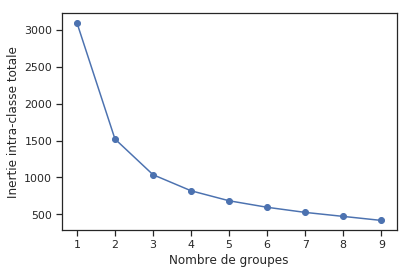

Centres des classes:
   heart_rate     steps  accelerometer
0   -0.301261 -0.472243      -0.207999
1    1.698390  1.838654       3.079090
2    1.077540  2.097786      -0.202000


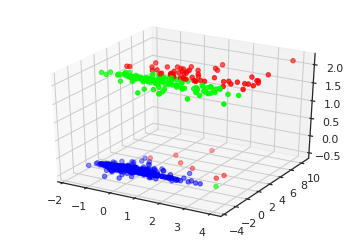

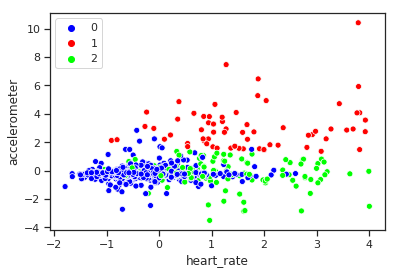

In [39]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 3
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

print('Centres des classes:')
print(centers_km)

plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['heart_rate'], X['accelerometer'], X['steps'],  c=km_labels, cmap='brg')


plt.show()
sns.scatterplot(X['heart_rate'],X['accelerometer'],  hue=km_labels, palette = 'brg')



# X['predictions'] = kmeans.labels_
# X['activity_type'] = smartwatch_df['activity_type'].tolist()

# for prediction in X['predictions'].unique():
#     proportions = []
#     labels = []
#     for activity_type in X[X['predictions'] == prediction]['activity_type'].unique():
#         p = X[X['predictions'] == prediction]['activity_type'].value_counts()[activity_type]
#         n = X['activity_type'].value_counts()[activity_type]
#         proportions.append(p/n)
#         labels.append(activity_type)
     
#     plt.show()
#     fig, ax = plt.subplots(figsize=(15,5))
#     sns.barplot(x = labels, y = proportions)
    
# X = X.drop('predictions', axis = 1)
# X = X.drop('activity_type', axis = 1)  

#### 5.2.2. Avec PCA

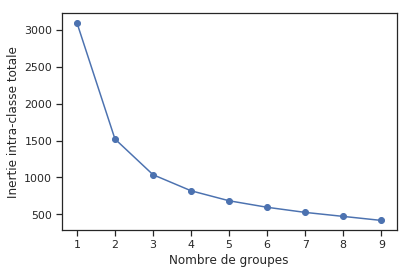

Centres des classes:
   heart_rate     steps  accelerometer
0   -0.577543  0.093962       0.121039
1    3.708520  1.408789      -0.090386
2    1.841179 -1.297934      -0.726657


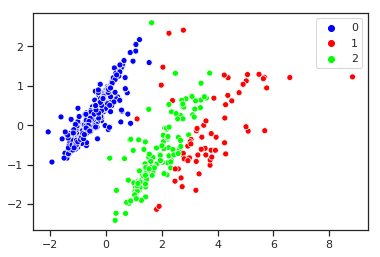

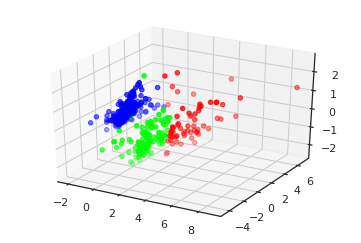

In [40]:
inerties = []
for i in range(1, 10):
    km = KMeans(n_clusters=i, 
                random_state=0)
    km.fit(X_pca)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Inertie intra-classe totale')
plt.show()

km_n_clusters_ = 3
kmeans = KMeans(n_clusters=km_n_clusters_, random_state=0).fit(X_pca)
km_labels = kmeans.labels_
km_n_clusters_ = len(np.unique(km_labels))
centers_km = pd.DataFrame(kmeans.cluster_centers_, columns=variables)

print('Centres des classes:')
print(centers_km)

# plt.show()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[], X['accelerometer'], X['steps'],  c=km_labels, cmap='brg')


# plt.show()
# sns.scatterplot(X['heart_rate'],X['accelerometer'],  hue=km_labels, palette = 'brg')


sns.scatterplot(X_pca[:, 0], X_pca[:, 2], hue=km_labels, palette = 'brg')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=km_labels, cmap='brg')
plt.show()


# X['predictions'] = kmeans.labels_
# X['activity_type'] = smartwatch_df['activity_type'].tolist()

# for prediction in X['predictions'].unique():
#     proportions = []
#     labels = []
#     for activity_type in X[X['predictions'] == prediction]['activity_type'].unique():
#         p = X[X['predictions'] == prediction]['activity_type'].value_counts()[activity_type]
#         n = X['activity_type'].value_counts()[activity_type]
#         proportions.append(p/n)
#         labels.append(activity_type)
     
#     plt.show()
#     fig, ax = plt.subplots(figsize=(15,5))
#     sns.barplot(x = labels, y = proportions)
    
# X = X.drop('predictions', axis = 1)
# X = X.drop('activity_type', axis = 1)  

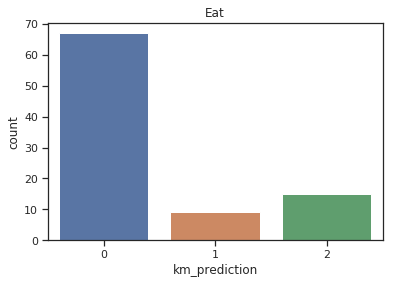

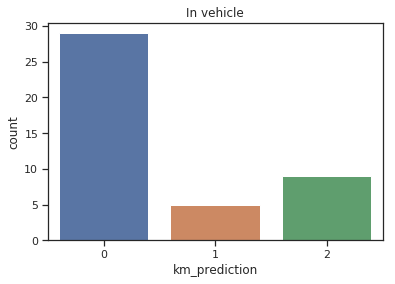

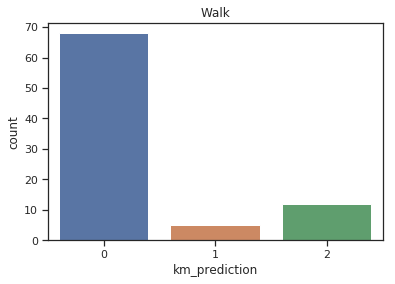

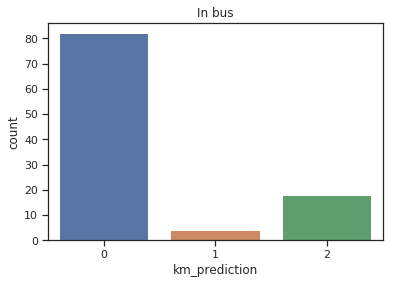

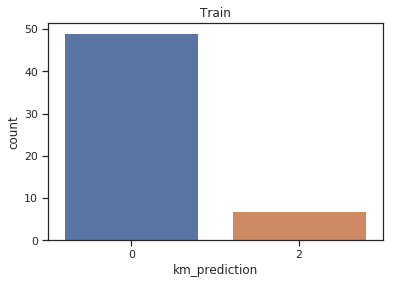

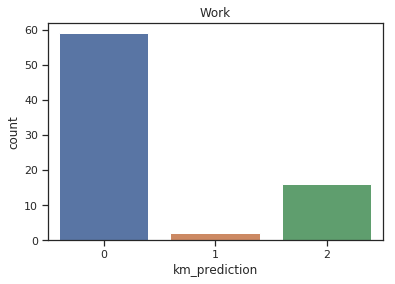

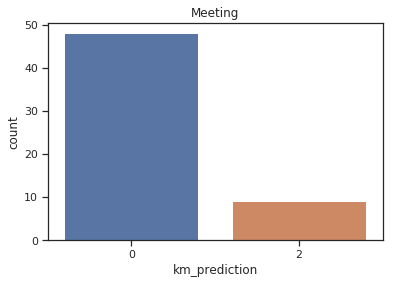

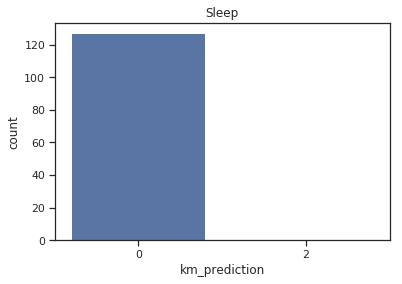

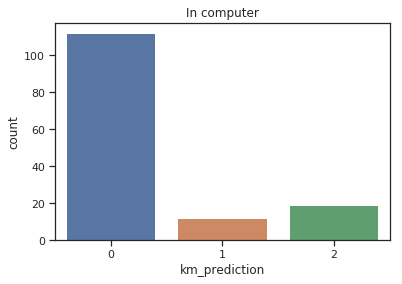

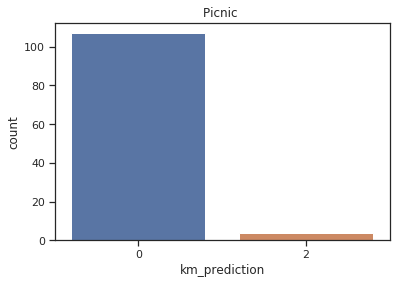

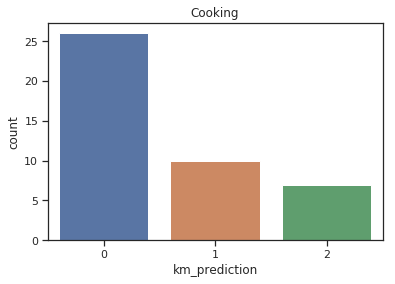

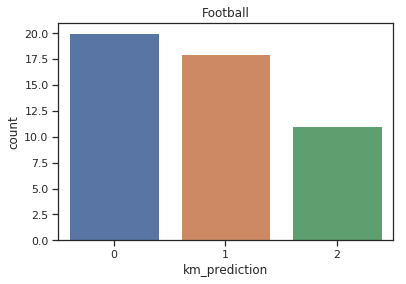

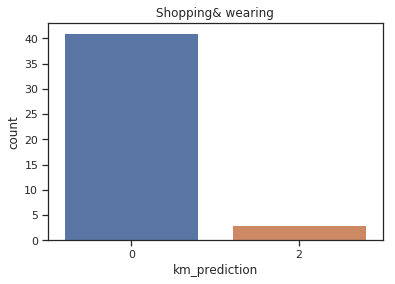

In [41]:
y = pd.DataFrame(y)
y['km_prediction']=km_labels
for activity_type in y['activity_type'].unique():
    data = y[y['activity_type'] == activity_type]
    plt.show()
    sns.countplot(x="km_prediction", data=data).set_title(activity_type)

In [ ]:
# list(y['activity_type'].unique())

### 5. Classification

#### Sans l'ACP:

In [42]:
activites_mobiles = ['Walk','Cooking', 'Football']
labels = []
for activity_type in list(y['activity_type']):
    if activity_type in activites_mobiles:
        labels.append(1)
    else:
        labels.append(0)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=101)

In [44]:
names = [
    "Nearest Neighbors",
    "Decision Tree", 
]

classifiers = [
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.78
Nearest Neighbors cross-validated scores: 
[0.70348837 0.71802326 0.73760933]




Decision Tree score: 0.82
Decision Tree cross-validated scores: 
[0.80523256 0.81976744 0.80758017]




#### Avec l'ACP:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.3, random_state=101)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    scores = cross_validate(clf, X, labels, cv=3, return_train_score=True)['test_score']
    print(name + ' cross-validated scores: ')
    print(scores)
    print("\n")
    



Nearest Neighbors score: 0.78
Nearest Neighbors cross-validated scores: 
[0.70348837 0.71802326 0.73760933]




Decision Tree score: 0.82
Decision Tree cross-validated scores: 
[0.80523256 0.81976744 0.80758017]


